# Analysis 5: Machine Learning-Based Asset Allocation under Political Uncertainty

**Duke University – Fuqua School of Business**  
**MQM Finance Capstone Project | Team 56**  
**Team Members**: Weicheng Wang, Qi Deng, Jiaying Sun, Omair Khan, Pavan Meka Kumar

---

This notebook presents **Analysis 5**, the culmination of our election-volatility research pipeline. Building on insights from prior analyses (1–4), we design a machine learning framework that transforms structured election scenarios into customized asset allocation recommendations for volatility-sensitive portfolios.

We use a **Random Forest regression model** trained on engineered features from U.S. presidential elections (2000–2024), including political characteristics (e.g., incumbency, crises, party switch) and corresponding volatility outcomes across major asset classes. The model learns a composite risk function derived from predicted and abnormal volatility—capturing both expected and shock-driven uncertainty.

The trained model powers a **client-facing allocation tool**, enabling users to input hypothetical election conditions and receive a pie-chart visualization of optimal asset weightings that minimize risk exposure.

> **Objective**: Bridge empirical volatility insights and political scenario modeling to generate robust, real-time investment guidance during election cycles.

## Final Objective Function: Election-Aware Portfolio Volatility Minimization

In this final analysis, we aim to develop a flexible asset allocation strategy that minimizes overall portfolio volatility during the post-election period. The strategy dynamically adjusts based on different U.S. presidential election scenarios, leveraging historical data from 2000 to 2024.

Our approach incorporates two core components of election-driven risk:

- **Expected volatility**, as predicted by GARCH models based on pre-election patterns.
- **Unexpected shocks**, measured as abnormal volatility (i.e., actual minus predicted post-election volatility).

---

### Objective Function

We define the optimization problem as:

$$
\min_{\mathbf{w}} \quad \sum_{i=1}^n w_i^2 \cdot \left( \hat{\sigma}_{i,\text{post}}^2 + \lambda \cdot \text{Abnormal}_i^2 \right)
$$

### where:

- $w_i$: Weight allocated to asset $i$  
- $\hat{\sigma}_{i,\text{post}}$: GARCH-predicted post-election standard deviation for asset $i$  
- $\text{Abnormal}_i$: Historical abnormal volatility for asset $i$ (actual − predicted)  
- $\lambda$: Penalty term to control influence of election-period shocks  
- $n$: Total number of assets (in our case, 6)

---

This objective function penalizes portfolios that allocate too much weight to assets with high expected volatility or large historical election surprises. The penalty factor $\lambda$ allows users to control sensitivity to election-related uncertainty.

This formulation provides a foundation for training and comparing machine learning models. The best-performing model will be embedded in our final client-facing tool, where users input their election expectations and receive personalized, volatility-aware portfolio recommendations.

---

### Our ML Model Will:

- Use **political scenario features** (from `US_Presidential_Elections_2000-2024.csv`)
- Learn to predict the **composite risk metric**:
  $$
  \text{Risk}_i = \hat{\sigma}_{i,\text{post}}^2 + \lambda \cdot \text{Abnormal}_i^2
  $$
- Feed predicted risk values into a **weighting engine**:
  $$
  \text{Allocation}_i = \frac{1 / \text{Risk}_i}{\sum_{j=1}^n 1 / \text{Risk}_j}
  $$
- Generate a user-facing output showing **optimal asset weights** under the user’s selected election scenario



## FAQ: Contributions from Analyses 1–4

| Analysis | Input File | Purpose | ML Contribution |
|---------|-------------|---------|------------------|
| **1. Long-Term Volatility** | `Master_Volatility_Index_Daily.csv` | Compute monthly variance across 4-year cycles; normalize to weights | Captures long-run asset-specific volatility for model generalization |
| **2. Phase-Based Volatility** | `Master_Volatility_Index_Daily.csv` | Measure asset volatility in Pre-Election, Election Month, Post-Election | Captures short-term volatility dynamics across phases |
| **3. Event Study (ARIMA/GARCH)** | `Combined_Event_Study_ARIMA_GARCH.csv` | Quantify predicted vs actual risk; compute abnormal volatility | Defines target:  $$\text{Custom\_Risk}_i = \hat{y}_i^2 + \lambda (\hat{\varepsilon}_i)^2$$ |
| **4. Political Feature Engineering** | `US_Presidential_Elections_2000-2024.csv` | Encode political scenarios into structured numeric variables | Forms election scenario feature inputs for prediction |



=== Model Comparison ===
              Model        MAE       RMSE
0             Ridge  28.103377  38.141156
1             Lasso  29.022365  37.946007
2      RandomForest  25.756800  35.217927
3  GradientBoosting  26.770568  39.164242


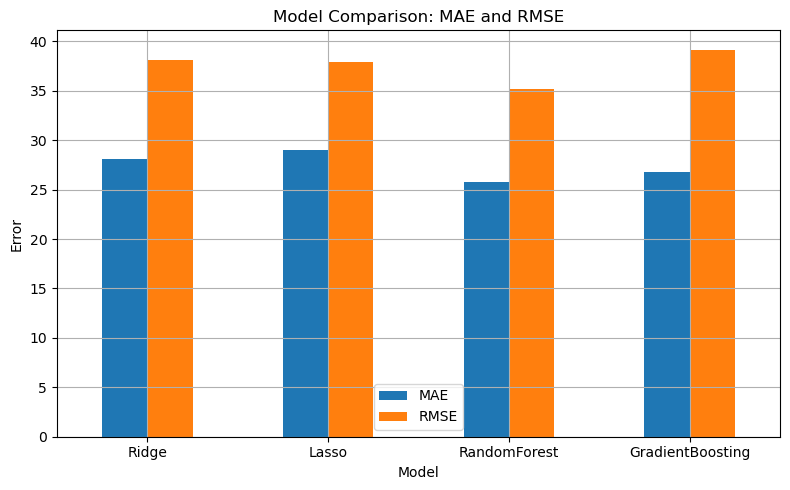

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from scipy.stats import randint, uniform

# === Load Data ===
base_path = '/Users/weichengwang/Desktop/DukeMQMBA_CourseFiles/[5] Spring 2 Term (3:17:2025 - 4:30:2025)/Capstone Project/Finalized_Data_Analysis_wk5/b_DataAnalysis'
df_event = pd.read_csv(f"{base_path}/Combined_Event_Study_ARIMA_GARCH.csv")
df_elections = pd.read_csv(f"{base_path}/US_Presidential_Elections_2000-2024.csv")

# === Merge and Clean ===
df_garch = df_event[df_event["Model"] == "GARCH"].copy()
df_full = df_garch.merge(df_elections, left_on="Election_Year", right_on="Year", how="left")

features = ['Index', 'Winning_Party', 'Incumbent_Reelected', 'Contested_Delayed',
            'Party_Switch', 'Electoral_Score', 'First_Term_President', 'Crisis']
df_full = df_full.dropna(subset=features + ['Predicted', 'Abnormal'])

# === Composite Risk Target ===
λ = 1.0
df_full['Custom_Risk'] = df_full['Predicted']**2 + λ * (df_full['Abnormal']**2)
X = df_full[features]
y = df_full['Custom_Risk']

# === Preprocessing with Fixed Categories ===
asset_categories = [['GVZ', 'OVX', 'TLT_IV30', 'VIX', 'VXEEM', 'VXN']]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(categories=asset_categories, drop='first', handle_unknown='ignore'), ['Index']),
    ('num', StandardScaler(), [col for col in features if col != 'Index'])
])

# === Scoring Metrics (without MAPE) ===
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}

# === Define Models ===
models = {
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('reg', RidgeCV(alphas=np.logspace(-3, 3, 10)))
    ]),
    'Lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('reg', LassoCV(alphas=np.logspace(-3, 2, 50), cv=5, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('reg', RandomizedSearchCV(
            RandomForestRegressor(random_state=42),
            param_distributions={
                'n_estimators': randint(100, 300),
                'max_depth': [3, 5, 10, None],
                'min_samples_split': randint(2, 6)
            },
            n_iter=10,
            cv=5,
            scoring='neg_mean_absolute_error',
            random_state=42
        ))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessor', preprocessor),
        ('reg', RandomizedSearchCV(
            GradientBoostingRegressor(random_state=42),
            param_distributions={
                'n_estimators': randint(100, 300),
                'max_depth': [3, 4, 5],
                'learning_rate': uniform(0.01, 0.2)
            },
            n_iter=10,
            cv=5,
            scoring='neg_mean_absolute_error',
            random_state=42
        ))
    ])
}

# === Train and Evaluate Models ===
results = {}
for name, pipeline in models.items():
    pipeline.fit(X, y)
    scores = cross_validate(pipeline, X, y, scoring=scoring, cv=5)
    results[name] = {
        'MAE': -np.mean(scores['test_MAE']),
        'RMSE': -np.mean(scores['test_RMSE']),
    }

# === Display Results ===
result_table = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
print("\n=== Model Comparison ===")
print(result_table)

# === Plot MAE and RMSE as bar charts ===
ax = result_table.set_index('Model')[['MAE', 'RMSE']].plot(
    kind='bar', 
    figsize=(8, 5), 
    grid=True, 
    rot=0
)
ax.set_title('Model Comparison: MAE and RMSE')
ax.set_ylabel('Error')
ax.set_xlabel('Model')
plt.tight_layout()
plt.show()

In [7]:
# We are proceeding with Random Forest Model as our optimizer to optimize our objective function.

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import randint
import joblib

# === Load Data ===
base_path = '/Users/weichengwang/Desktop/DukeMQMBA_CourseFiles/[5] Spring 2 Term (3:17:2025 - 4:30:2025)/Capstone Project/Finalized_Data_Analysis_wk5/b_DataAnalysis'
df_event = pd.read_csv(f"{base_path}/Combined_Event_Study_ARIMA_GARCH.csv")
df_elections = pd.read_csv(f"{base_path}/US_Presidential_Elections_2000-2024.csv")

# === Merge and Clean ===
df_garch = df_event[df_event["Model"] == "GARCH"].copy()
df_full = df_garch.merge(df_elections, left_on="Election_Year", right_on="Year", how="left")

features = ['Index', 'Winning_Party', 'Incumbent_Reelected', 'Contested_Delayed',
            'Party_Switch', 'Electoral_Score', 'First_Term_President', 'Crisis']
df_full = df_full.dropna(subset=features + ['Predicted', 'Abnormal'])

# === Composite Risk Target ===
λ = 1.0
df_full['Custom_Risk'] = df_full['Predicted']**2 + λ * (df_full['Abnormal']**2)
X = df_full[features]
y = df_full['Custom_Risk']

# === Preprocessing ===
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), ['Index']),
    ('num', StandardScaler(), [col for col in features if col != 'Index'])
])

# === Random Forest with Random Search ===
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions={
        'n_estimators': randint(100, 300),
        'max_depth': [3, 5, 10, None],
        'min_samples_split': randint(2, 6)
    },
    n_iter=10,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42
)

# === Pipeline ===
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_search)
])

# === Train Model and Save Pipeline ===
rf_pipeline.fit(X, y)
joblib.dump(rf_pipeline, 'final_rf_pipeline.pkl')

['final_rf_pipeline.pkl']

Welcome to the Election-Based Asset Allocation Tool

Please answer the following questions with 0 (No/Republican) or 1 (Yes/Democrat).


1. Winning Party? (Democrat=1, Republican=0):  0
2. Was the incumbent re-elected? (Yes=1, No=0):  1
3. Was the election contested or delayed? (Yes=1, No=0):  0
4. Did party control switch? (Yes=1, No=0):  1
5. Electoral strength? (1 = Weak ... 5 = Strong):  4
6. First-term president? (Yes=1, No=0):  0
7. Crisis during the election? (Yes=1, No=0):  0



=== Recommended Portfolio Allocation Based on Your Scenario ===
           Asset  Allocation (%)
            Gold           19.58
             Oil           15.10
   30Yr Treasury           14.10
         S&P 500           15.43
Emerging Markets           15.94
          Nasdaq           19.85


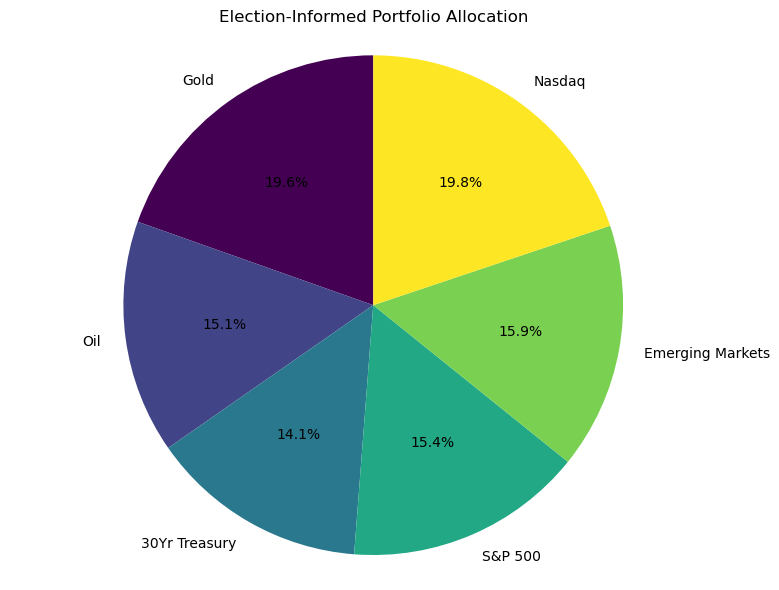

In [9]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# === Load full trained pipeline ===
rf_pipeline = joblib.load('final_rf_pipeline.pkl')

# === Prompt client for election scenario inputs ===
def get_user_inputs():
    print("Welcome to the Election-Based Asset Allocation Tool\n")
    print("Please answer the following questions with 0 (No/Republican) or 1 (Yes/Democrat).")
    inputs = {}
    inputs['Winning_Party'] = int(input("1. Winning Party? (Democrat=1, Republican=0): "))
    inputs['Incumbent_Reelected'] = int(input("2. Was the incumbent re-elected? (Yes=1, No=0): "))
    inputs['Contested_Delayed'] = int(input("3. Was the election contested or delayed? (Yes=1, No=0): "))
    inputs['Party_Switch'] = int(input("4. Did party control switch? (Yes=1, No=0): "))
    inputs['Electoral_Score'] = int(input("5. Electoral strength? (1 = Weak ... 5 = Strong): "))
    inputs['First_Term_President'] = int(input("6. First-term president? (Yes=1, No=0): "))
    inputs['Crisis'] = int(input("7. Crisis during the election? (Yes=1, No=0): "))
    return inputs

# === Generate allocation recommendations ===
def get_allocation_from_scenario(user_inputs):
    index_names = ['GVZ', 'OVX', 'TLT_IV30', 'VIX', 'VXEEM', 'VXN']
    df_input = pd.DataFrame([{**user_inputs, 'Index': idx} for idx in index_names])

    df_input['Predicted_Risk'] = rf_pipeline.predict(df_input)
    df_input['Inverse_Risk'] = 1 / df_input['Predicted_Risk']
    df_input['Allocation'] = df_input['Inverse_Risk'] / df_input['Inverse_Risk'].sum()

    index_to_asset = {
        'GVZ': 'Gold',
        'OVX': 'Oil',
        'TLT_IV30': '30Yr Treasury',
        'VIX': 'S&P 500',
        'VXEEM': 'Emerging Markets',
        'VXN': 'Nasdaq'
    }
    df_input['Asset'] = df_input['Index'].map(index_to_asset)

    result = df_input[['Asset', 'Allocation']].copy()
    result['Allocation (%)'] = (result['Allocation'] * 100).round(2)
    return result

# === Run the tool ===
if __name__ == "__main__":
    user_input = get_user_inputs()
    allocation_df = get_allocation_from_scenario(user_input)

    print("\n=== Recommended Portfolio Allocation Based on Your Scenario ===")
    print(allocation_df[['Asset', 'Allocation (%)']].to_string(index=False))

    # === Pie chart visualization ===
    plt.figure(figsize=(8, 6))
    plt.pie(allocation_df['Allocation'], labels=allocation_df['Asset'],
            autopct='%1.1f%%', startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(allocation_df))))
    plt.title("Election-Informed Portfolio Allocation")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()